# HAT-P-32

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import lightkurve as lk
from glob import glob
import ombre as om
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

import astropy.units as u

In [15]:
name = 'HAT-P-32'

In [16]:
fnames = np.asarray(glob(f'/Volumes/Nibelheim/hst/data/{name}/*.fits'))
fnames = np.sort(fnames)
obs = om.Observation.from_files(fnames)

In [19]:
lk.search_lightcurve(name)

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 18,2019,TESS-SPOC,1800,292152376,0.0
1,TESS Sector 18,2019,QLP,1800,292152376,0.0


In [20]:
clc = lk.search_lightcurve(name, author='TESS-SPOC').download_all().stitch().remove_nans()
clc.flux = clc.flux.value * u.electron/u.s
clc.flux_err = clc.flux_err.value * u.electron/u.s

In [21]:
k = np.abs(((clc.time.value - (obs.t0 - 2457000 + obs.period/2))/obs.period) % 1 - 0.5) < 0.1

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

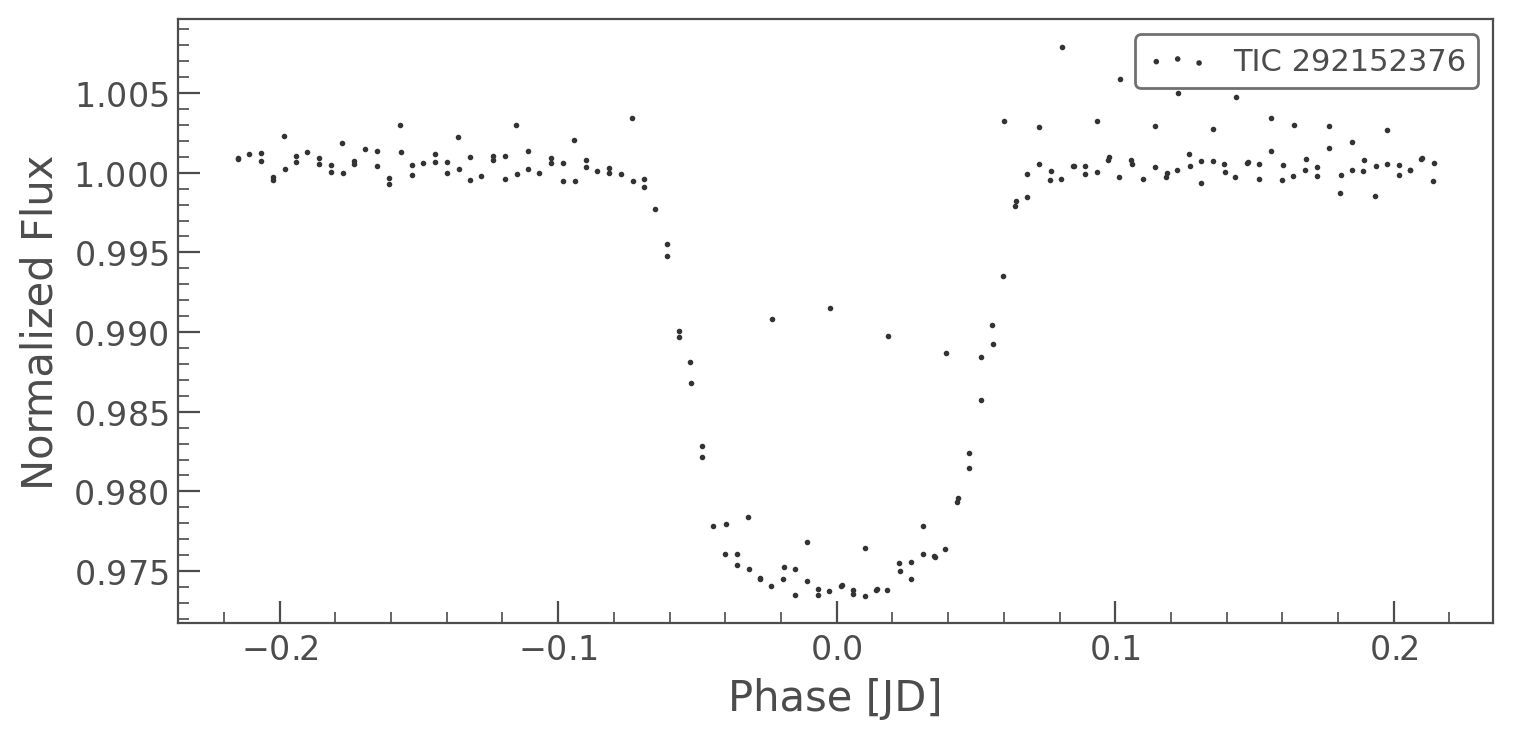

In [22]:
clc[k].fold(obs.period, obs.t0 - 2457000).scatter()

In [23]:
obs.fit_transit(x_suppl=clc.time.value[k] + 2457000,
                y_suppl=clc.flux.value[k],
                yerr_suppl=clc.flux_err.value[k],
                exptime_suppl=np.median(np.diff(clc.time.value)), fit_t0=True, fit_period=True, fit_inc=True)

<AxesSubplot:xlabel='Phase', ylabel='$e^-s^{-1}$'>

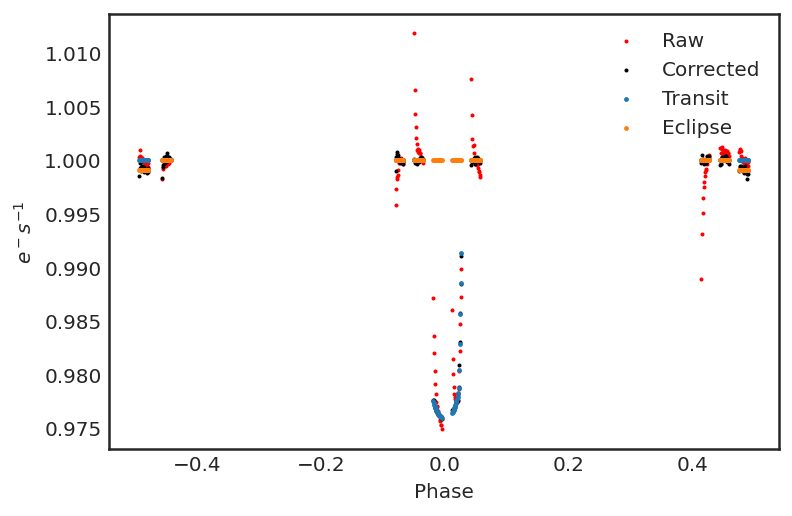

In [24]:
obs.plot()

In [25]:
obs.fit_model()

Fitting Transit/Eclipse Model: 100%|██████████████| 2/2 [00:18<00:00,  9.45s/it]


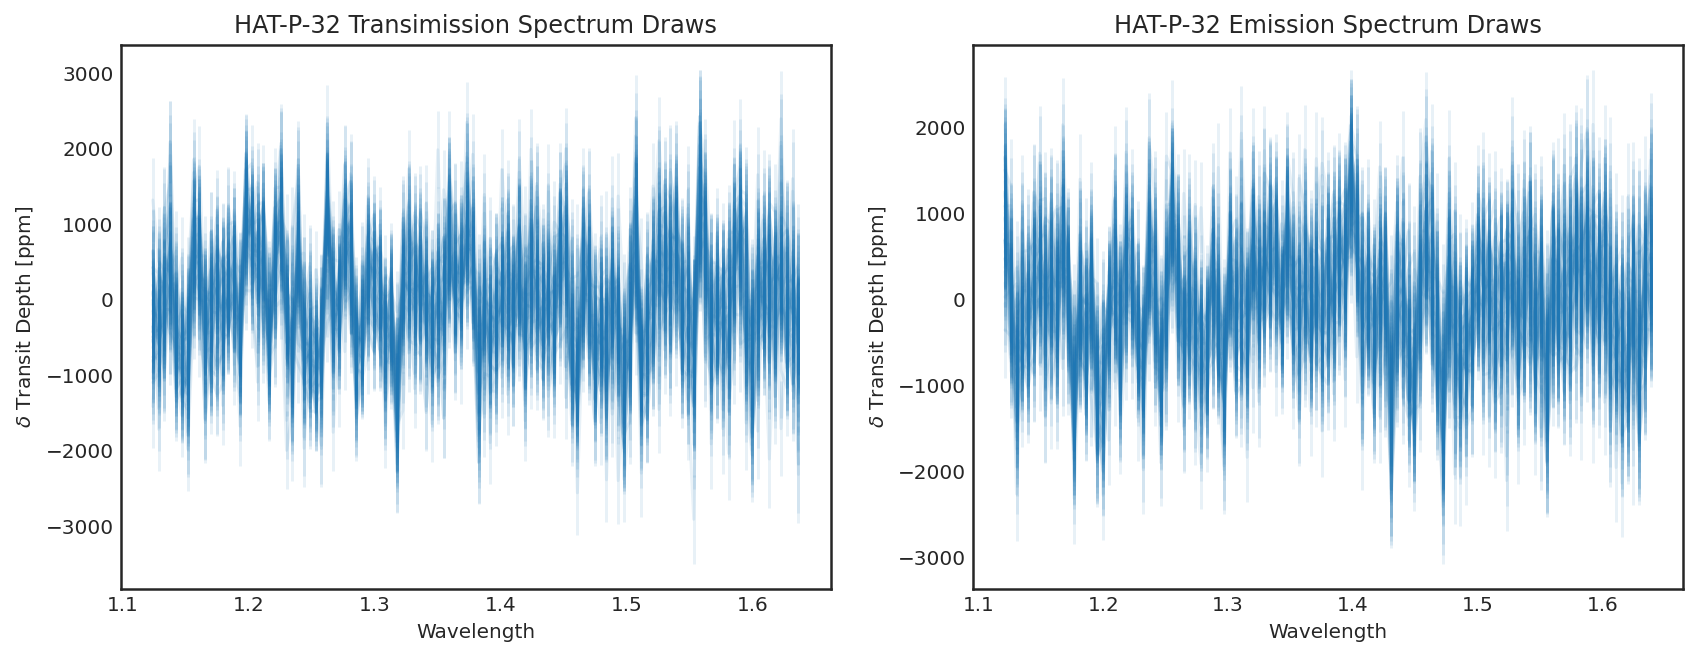

In [26]:
obs.plot_spectra()

<AxesSubplot:title={'center':'HAT-P-32 Transmission Spectrum, Visit: 1'}, xlabel='Wavelength', ylabel='$\\delta$ Transit Depth [ppm]'>

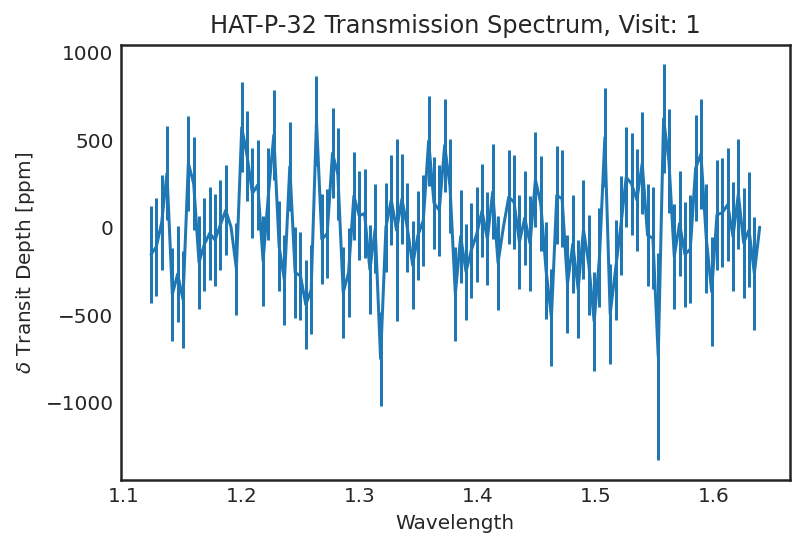

In [31]:
om.Spectra([visit.transmission_spectrum for visit in obs]).flatten().bin(bins=np.linspace(0.8, 1.7, 200)).plot()

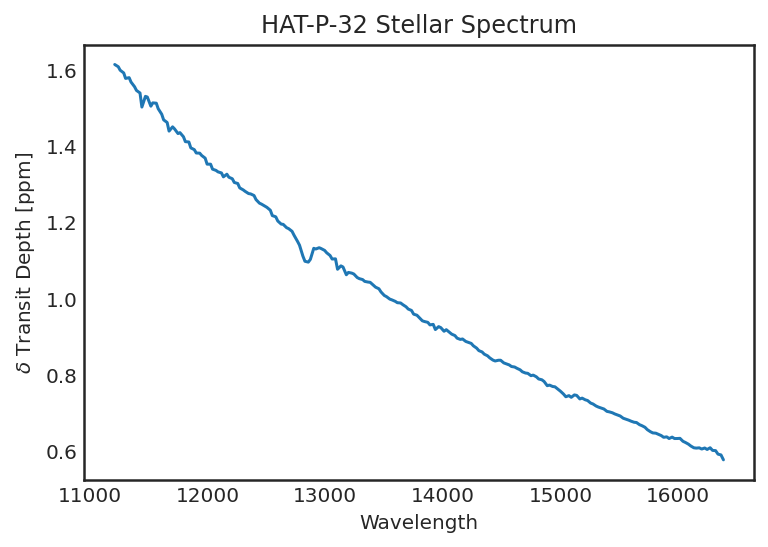

In [28]:
spec = obs.stellar_spectra
spec.plot()
spec.hdulist.writeto(f'results/{name}_stellar_spectrum.fits', overwrite=True)

In [29]:
from astropy.io import fits
try:
    hdulist = om.Spectra([visit.transmission_spectrum for visit in obs if visit.transmission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_transmission.fits', overwrite=True)
except:
    pass
try:    
    hdulist = om.Spectra([visit.emission_spectrum for visit in obs if visit.emission_spectrum.spec.sum() != 0]).hdulist
    hdulist.writeto(f'results/{name}_emission.fits', overwrite=True)
except:
    pass

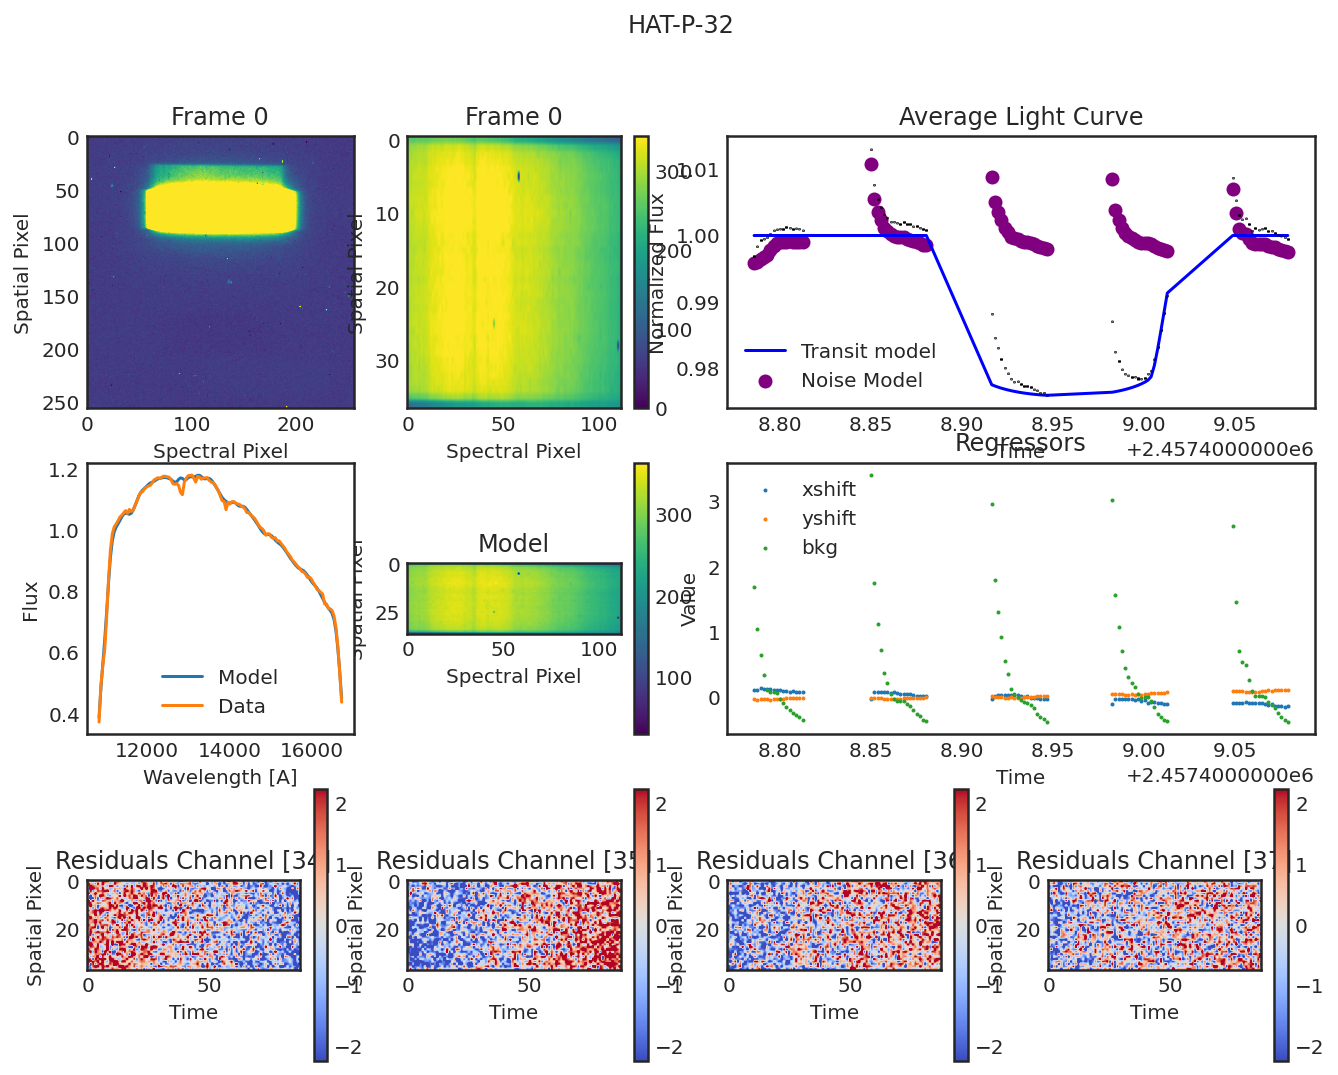

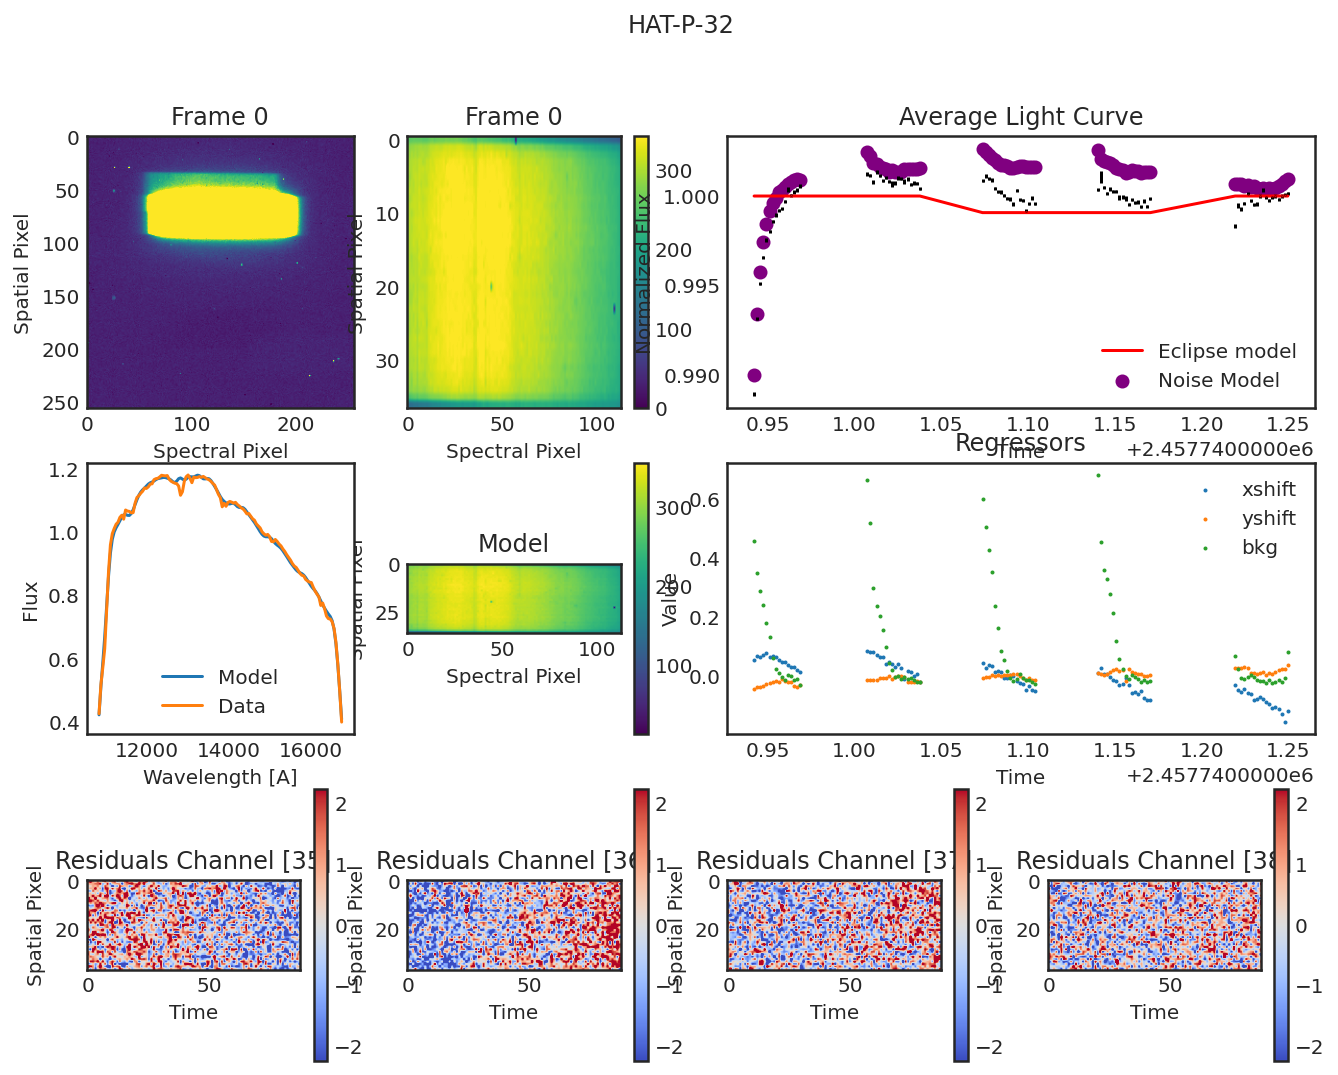

In [30]:
for visit in obs:
    visit.diagnose();
    plt.show();